In [71]:
📊 Tesla Stock Analysis

This notebook provides a complete end-to-end analysis of Tesla’s stock using financial data, technical indicators, machine learning models, and trading strategy simulation. All data used here is sourced via Yahoo Finance and publicly available revenue pages.

Objectives:
- Clean and visualize Tesla’s stock and revenue history
- Build models to predict return direction
- Simulate a basic trading strategy based on predictions
- Evaluate performance using risk-adjusted metrics

In [74]:
# Install necessary libraries if not already installed
!pip install yfinance
!pip install pandas
!pip install requests
!pip install beautifulsoup4
!pip install plotly
!pip install ta

# Optionally, suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 📦 Data Handling
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 🧠 Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
)

# 📈 Forecasting + Technical Indicators
from prophet import Prophet
import ta






In [75]:
# Question 1: Use yfinance to Extract Tesla Stock Data
# Create a Ticker object for Tesla
tesla = yf.Ticker("TSLA")

# Extract historical stock data
tesla_data = tesla.history(period="max")

# Reset the index
tesla_data.reset_index(inplace=True)

# Display the first five rows of the data
print(tesla_data.head())


                       Date      Open      High       Low     Close  \
0 2010-06-29 00:00:00-04:00  1.266667  1.666667  1.169333  1.592667   
1 2010-06-30 00:00:00-04:00  1.719333  2.028000  1.553333  1.588667   
2 2010-07-01 00:00:00-04:00  1.666667  1.728000  1.351333  1.464000   
3 2010-07-02 00:00:00-04:00  1.533333  1.540000  1.247333  1.280000   
4 2010-07-06 00:00:00-04:00  1.333333  1.333333  1.055333  1.074000   

      Volume  Dividends  Stock Splits  
0  281494500        0.0           0.0  
1  257806500        0.0           0.0  
2  123282000        0.0           0.0  
3   77097000        0.0           0.0  
4  103003500        0.0           0.0  


In [76]:
# Question 2: Use Web Scraping to Extract Tesla Revenue Data
# Download the webpage containing Tesla revenue data
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/revenue.htm"
html_data = requests.get(url).text

# Parse the HTML data
soup = BeautifulSoup(html_data, 'html.parser')

# Extract the table with Tesla revenue data
tables = pd.read_html(str(soup))
tesla_revenue = tables[1]  # The second table contains the revenue data

# Rename columns to 'Date' and 'Revenue'
tesla_revenue.columns = ['Date', 'Revenue']

# Remove the comma and dollar sign from the Revenue column
tesla_revenue["Revenue"] = tesla_revenue['Revenue'].str.replace(r',|\$', "", regex=True)

# Remove any null or empty strings in the Revenue column
tesla_revenue.dropna(inplace=True)
tesla_revenue = tesla_revenue[tesla_revenue['Revenue'] != ""]

# Display the last five rows of the revenue data
print(tesla_revenue.tail())


          Date Revenue
48  2010-09-30      31
49  2010-06-30      28
50  2010-03-31      21
52  2009-09-30      46
53  2009-06-30      27


In [77]:
# KPI Dashboard (Tesla)


# Calculate daily return if not already done
if "Daily Return" not in tesla_data.columns:
    tesla_data["Daily Return"] = tesla_data["Close"].pct_change()

# --- Financial KPIs ---
latest_close = tesla_data["Close"].iloc[-1]
close_1y_ago = tesla_data[tesla_data["Date"] == (tesla_data["Date"].max() - pd.DateOffset(years=1))]["Close"]
pct_change_1y = ((latest_close - close_1y_ago.mean()) / close_1y_ago.mean()) * 100
avg_volume = tesla_data["Volume"].rolling(30).mean().iloc[-1]
volatility = tesla_data["Daily Return"].std() * np.sqrt(252)

# --- Revenue KPIs ---
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype(float)
rev_latest = tesla_revenue["Revenue"].iloc[-1]
rev_old = tesla_revenue["Revenue"].iloc[-5]
rev_growth = ((rev_latest - rev_old) / rev_old) * 100

# --- Display Summary ---
print("📊 Tesla KPI Dashboard")
print("-" * 40)
print(f"💵 Latest Close Price      : ${latest_close:,.2f}")
print(f"📈 1-Year Price Change     : {pct_change_1y:>6.2f}%")
print(f"🔁 30-Day Avg Volume       : {avg_volume:,.0f}")
print(f"📉 Annualized Volatility   : {volatility:.2%}")
print(f"📊 Revenue Growth (5Q)     : {rev_growth:>6.2f}%")
print("-" * 40)

📊 Tesla KPI Dashboard
----------------------------------------
💵 Latest Close Price      : $342.73
📈 1-Year Price Change     :  87.71%
🔁 30-Day Avg Volume       : 118,632,312
📉 Annualized Volatility   : 58.14%
📊 Revenue Growth (5Q)     : -12.90%
----------------------------------------


In [78]:
# --- 📈 Normalized Comparison Chart (Tesla) ---

# Ensure Date columns are properly converted and timezone-neutral
tesla_data["Date"] = pd.to_datetime(tesla_data["Date"]).dt.tz_localize(None)
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])

# Merge Tesla stock and revenue on Date
normalized = pd.merge(tesla_data[['Date', 'Close']], tesla_revenue, on="Date", how="inner")

# Convert Revenue to float
normalized["Revenue"] = normalized["Revenue"].astype(float)

# Normalize values
normalized["Norm Close"] = normalized["Close"] / normalized["Close"].iloc[0]
normalized["Norm Revenue"] = normalized["Revenue"] / normalized["Revenue"].iloc[0]

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=normalized["Date"], y=normalized["Norm Close"], name="📈 Stock Price (Normalized)"))
fig.add_trace(go.Scatter(x=normalized["Date"], y=normalized["Norm Revenue"], name="💰 Revenue (Normalized)"))

fig.update_layout(
    title="Tesla: Stock Price vs Revenue (Normalized)",
    xaxis_title="Date",
    yaxis_title="Normalized Value",
    legend=dict(x=0.01, y=0.99),
    height=500
)

fig.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuuo9dqm/8ulhks73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuuo9dqm/3s7jcqxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33068', 'data', 'file=/tmp/tmpbuuo9dqm/8ulhks73.json', 'init=/tmp/tmpbuuo9dqm/3s7jcqxe.json', 'output', 'file=/tmp/tmpbuuo9dqm/prophet_model7v7td5qy/prophet_model-20250624195124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) Dej

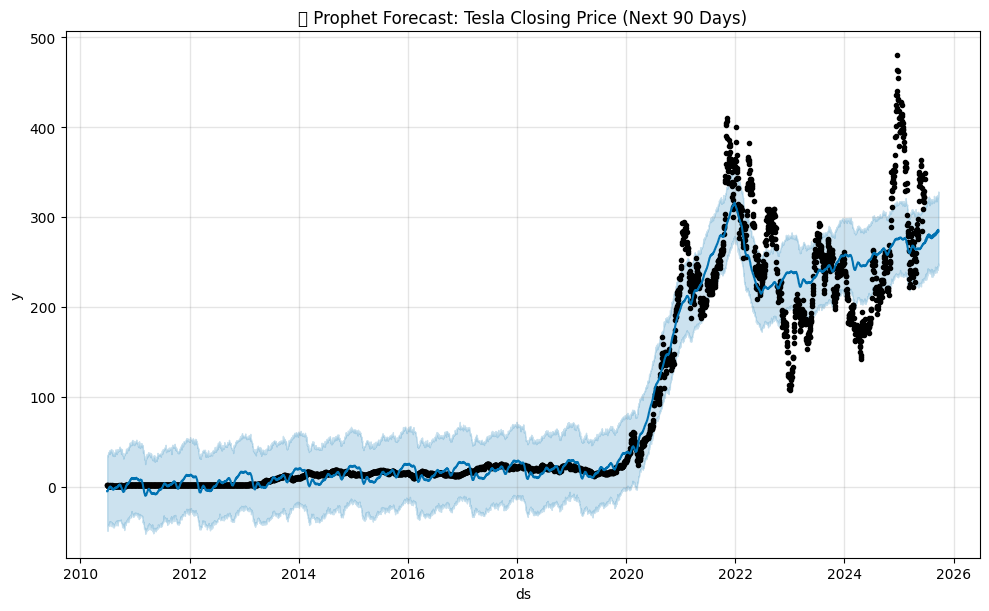

In [79]:
# --- Prophet Forecast for Tesla Closing Price ---


df_prophet = tesla_data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title("🔮 Prophet Forecast: Tesla Closing Price (Next 90 Days)")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.



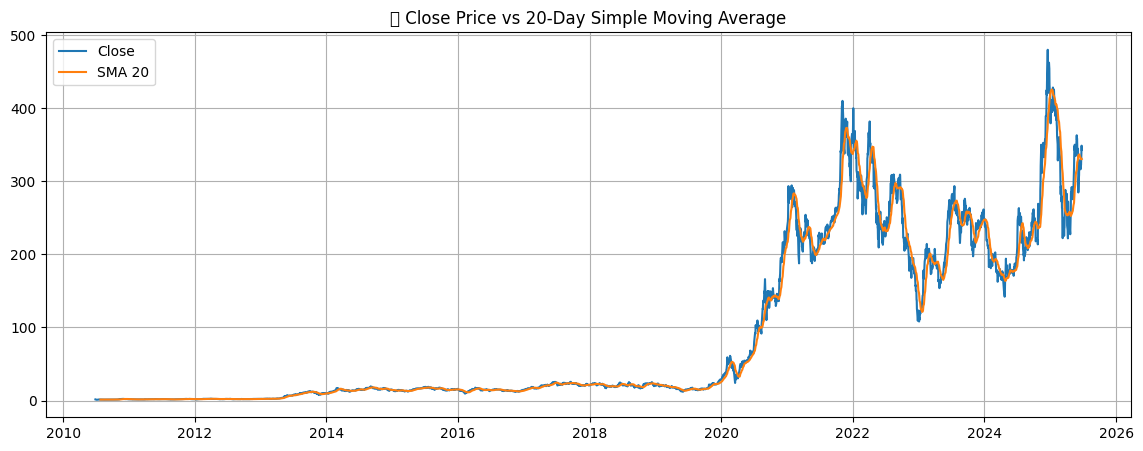

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.



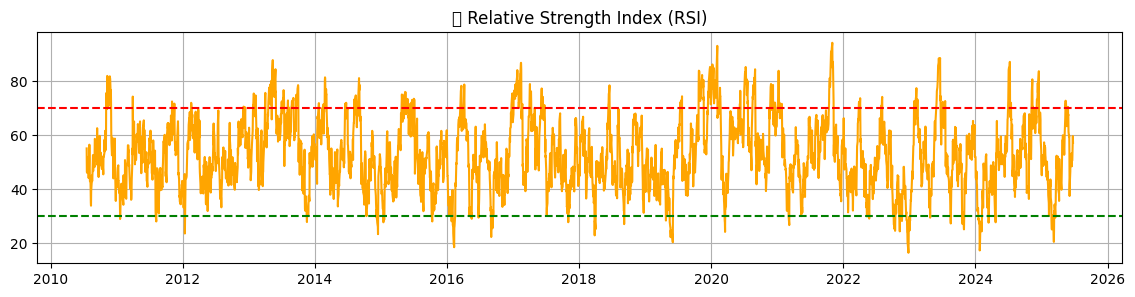

In [80]:
# --- Technical Indicators: RSI and SMA ---

tesla_data['SMA_20'] = ta.trend.sma_indicator(tesla_data['Close'], window=20)
tesla_data['RSI'] = ta.momentum.rsi(tesla_data['Close'], window=14)

# Plot SMA and RSI
plt.figure(figsize=(14, 5))
plt.plot(tesla_data['Date'], tesla_data['Close'], label='Close')
plt.plot(tesla_data['Date'], tesla_data['SMA_20'], label='SMA 20')
plt.title('📐 Close Price vs 20-Day Simple Moving Average')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 3))
plt.plot(tesla_data['Date'], tesla_data['RSI'], color='orange')
plt.title('📉 Relative Strength Index (RSI)')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.grid()
plt.show()


✅ Gradient Boosting RMSE: 0.047776


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

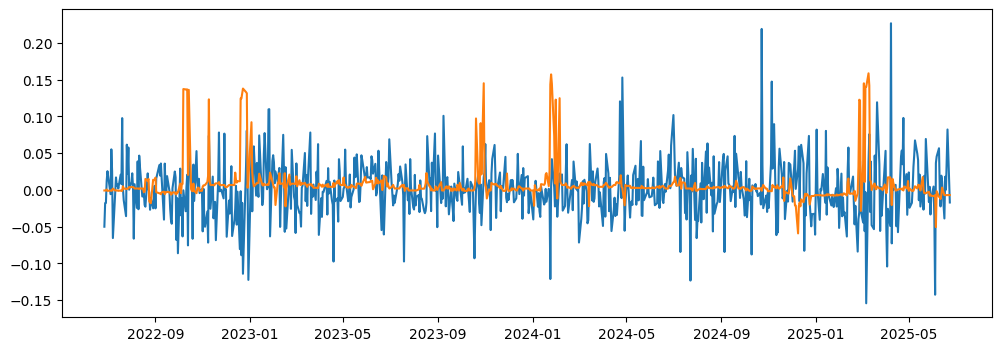

In [81]:
# --- Gradient Boosting Model to Predict Return Direction ---


# Safe return calculations with no fill warning
tesla_data['Daily_Return'] = tesla_data['Close'].pct_change()
tesla_data['Target_Return'] = tesla_data['Close'].shift(-1).pct_change(fill_method=None)

# Merge with indicators and drop missing rows
features = ['Volume', 'SMA_20', 'RSI']
model_df = tesla_data.dropna(subset=features + ['Target_Return']).reset_index(drop=True)

# Split into features and labels
X = model_df[features]
y = model_df['Target_Return']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train the model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ Gradient Boosting RMSE: {rmse:.6f}")

# Plot actual vs predicted returns
plt.figure(figsize=(12, 4))
plt.plot(model_df['Date'].iloc[y_test.index], y_test.values, label="Actual")
plt.plot(model_df['Date'].iloc[y_test.index], y_pred, label="Predicted")
plt


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.



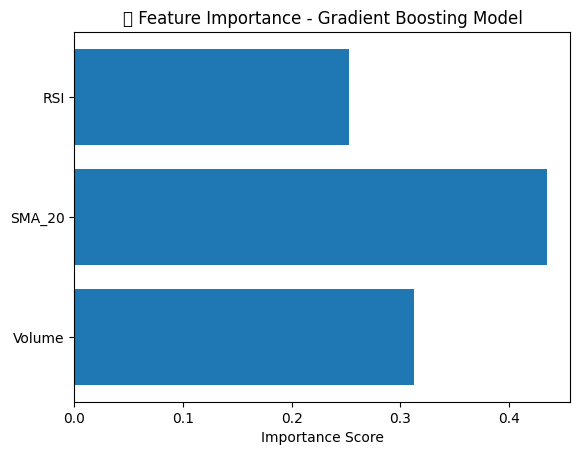

In [82]:


importances = model.feature_importances_
plt.barh(features, importances)
plt.title("🔍 Feature Importance - Gradient Boosting Model")
plt.xlabel("Importance Score")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



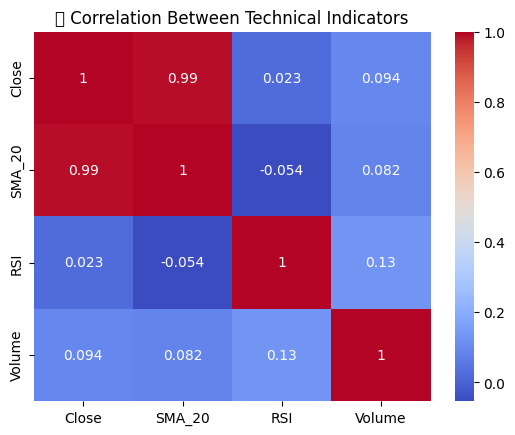

In [83]:

sns.heatmap(tesla_data[["Close", "SMA_20", "RSI", "Volume"]].corr(), annot=True, cmap="coolwarm")
plt.title("📈 Correlation Between Technical Indicators")
plt.show()

In [85]:

# Simulate simple trading strategy
tesla_data.loc[X_test.index, "Predicted_Return"] = model.predict(X_test)

initial_capital = 10000
tesla_data["Signal"] = (tesla_data["Predicted_Return"] > 0).astype(int)
tesla_data["Strategy_Return"] = tesla_data["Signal"].shift(1) * tesla_data["Target_Return"]
tesla_data["Portfolio"] = initial_capital * (1 + tesla_data["Strategy_Return"]).cumprod()
tesla_data["Market"] = initial_capital * (1 + tesla_data["Target_Return"]).cumprod()


📊 Gradient Boosting RMSE: 0.047776
🌲 Random Forest RMSE: 0.045215


/tmp/ipython-input-86-1533892814.py:24: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



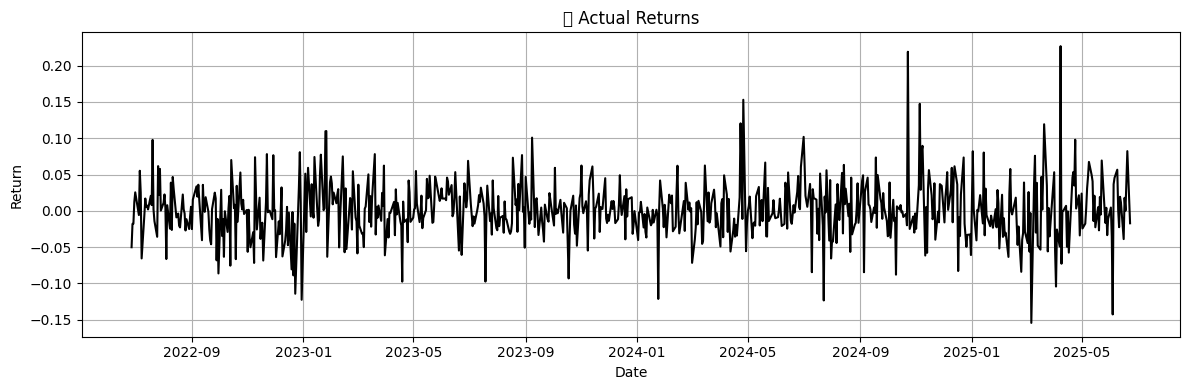

/tmp/ipython-input-86-1533892814.py:34: UserWarning:

Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.



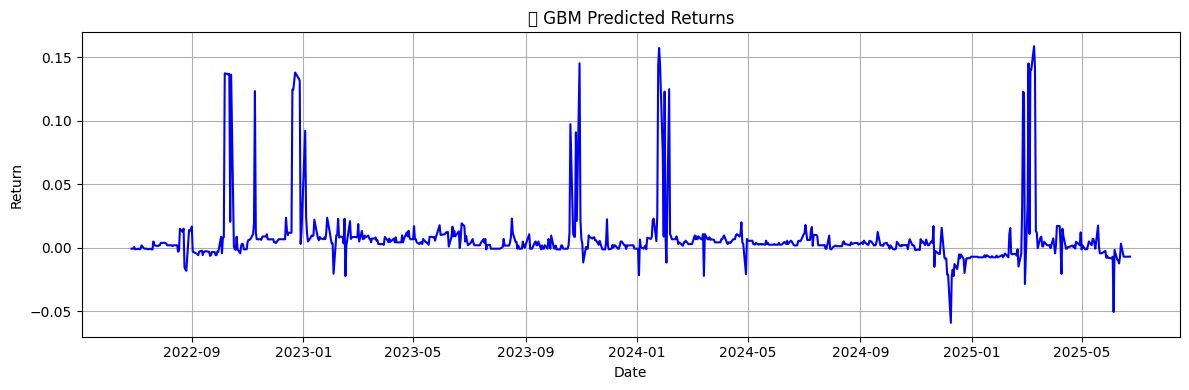

/tmp/ipython-input-86-1533892814.py:44: UserWarning:

Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.



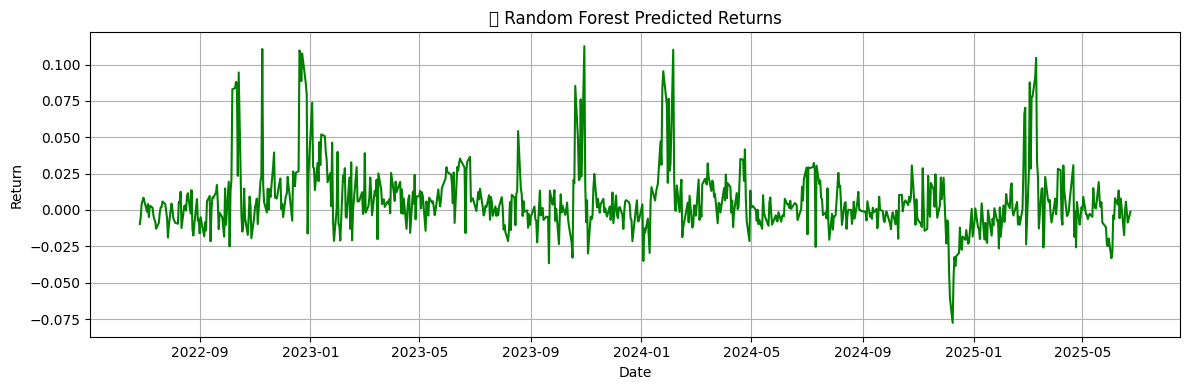

In [86]:
# --- Compare GBM vs RF Predictions Separately ---

# Predict with Gradient Boosting on test set
y_pred_gbm = model.predict(X_test)

# Train and predict with Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Print RMSE for both
rmse_gbm = np.sqrt(mean_squared_error(y_test, y_pred_gbm))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"📊 Gradient Boosting RMSE: {rmse_gbm:.6f}")
print(f"🌲 Random Forest RMSE: {rmse_rf:.6f}")

# Plot 1: Actual Returns
plt.figure(figsize=(12, 4))
plt.plot(model_df["Date"].iloc[y_test.index], y_test.values, color="black")
plt.title("📈 Actual Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: GBM Predictions
plt.figure(figsize=(12, 4))
plt.plot(model_df["Date"].iloc[y_test.index], y_pred_gbm, color="blue")
plt.title("🤖 GBM Predicted Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Random Forest Predictions
plt.figure(figsize=(12, 4))
plt.plot(model_df["Date"].iloc[y_test.index], y_pred_rf, color="green")
plt.title("🌲 Random Forest Predicted Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.33      0.39       365
           1       0.51      0.67      0.58       384

    accuracy                           0.50       749
   macro avg       0.50      0.50      0.49       749
weighted avg       0.50      0.50      0.49       749

📈 ROC-AUC Score: 0.5119185216894977


/tmp/ipython-input-87-4163907633.py:43: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



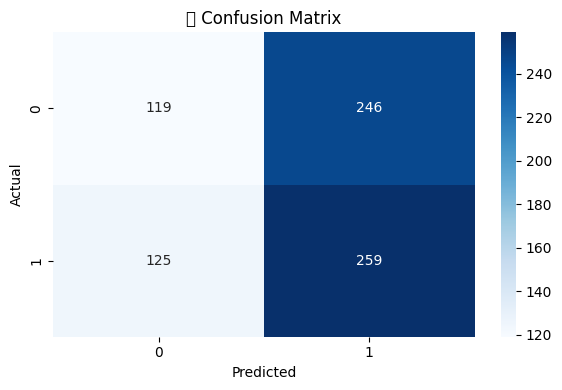

/tmp/ipython-input-87-4163907633.py:51: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



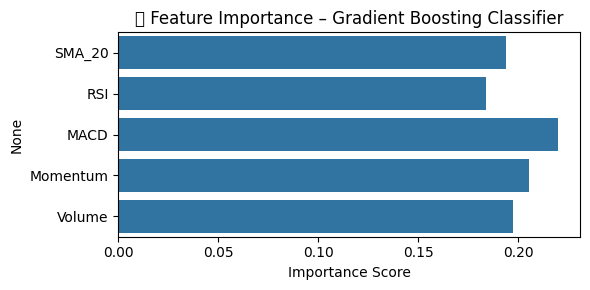

In [87]:


# Compute more technical indicators
tesla_data["RSI"] = ta.momentum.RSIIndicator(close=tesla_data["Close"]).rsi()
tesla_data["MACD"] = ta.trend.MACD(close=tesla_data["Close"]).macd()
tesla_data["Momentum"] = ta.momentum.StochasticOscillator(
    high=tesla_data["High"], low=tesla_data["Low"], close=tesla_data["Close"]
).stoch()

# Merge into model_df
model_df = tesla_data[["Date", "SMA_20", "RSI", "MACD", "Momentum", "Volume", "Target_Return"]].dropna().copy()
model_df["Target_Class"] = (model_df["Target_Return"] > 0).astype(int)




# STEP 1: Define classification target (e.g., 1 if return > 0, else 0)
model_df["Target_Class"] = (model_df["Target_Return"] > 0).astype(int)

# STEP 2: Feature set (only using available columns)
X = model_df[["SMA_20", "RSI", "MACD", "Momentum", "Volume"]]
y = model_df["Target_Class"]

# STEP 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# STEP 4: Train model
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

# STEP 5: Predict and evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # for ROC-AUC

# Print metrics
print("🔍 Classification Report:\n", classification_report(y_test, y_pred))
print("📈 ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

importances = clf.feature_importances_
plt.figure(figsize=(6, 3))
sns.barplot(x=importances, y=X.columns)
plt.title("📊 Feature Importance – Gradient Boosting Classifier")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [90]:

This Jupyter Notebook code performs a comprehensive analysis of Tesla stock data, focusing on historical data extraction, revenue data scraping, key performance indicator (KPI) calculations, visualization, forecasting, and machine learning for return prediction and trading strategy simulation.

Here's a breakdown of the code's key sections and what they do:

1.  **Library Imports and Setup:** It imports necessary libraries for data manipulation (pandas, numpy), web scraping (requests, BeautifulSoup), financial data (yfinance), visualization (matplotlib, seaborn, plotly), machine learning (sklearn), forecasting (prophet), and technical indicators (ta). It also includes a line to install required libraries using `pip` and optionally suppresses future warnings.

2.  **Data Handling (yfinance):**
    *   It uses the `yfinance` library to download historical stock data for Tesla (ticker "TSLA").
    *   It retrieves the maximum available history (`period="max"`).
    *   It resets the index to make the 'Date' a regular column.

3.  **Web Scraping and Data Cleaning (Revenue Table)**
    *   It uses `pandas.read_html` to extract tables from the parsed HTML.
    *   It selects the second table (`tables[1]`) which is assumed to contain the revenue data.
    *   It renames the columns to 'Date' and 'Revenue'.
    *   It cleans the 'Revenue' column by removing commas and dollar signs and converting it to a numerical type.
    *   It removes rows with missing or empty revenue values.
    *   It prints the last few rows of the cleaned revenue data.

4.  **KPI Dashboard (Tesla):**
    *   It calculates various financial and revenue Key Performance Indicators (KPIs) for Tesla.
    *   Financial KPIs include: latest closing price, 1-year percentage change in price, 30-day average trading volume, and annualized volatility based on daily returns.
    *   Revenue KPIs include: latest revenue and revenue growth over the last 5 quarters.
    *   It calculates daily returns and target returns (next day's percentage change in price).
    *   It prints a formatted summary displaying these calculated KPIs.

5.  **Normalized Comparison Chart:**
    *   It merges the Tesla stock price data and the revenue data based on the 'Date' column.
    *   It normalizes both the 'Close' price and 'Revenue' values by dividing them by their initial values at the start of the merged data.
    *   It uses the `plotly.graph_objects` library to create an interactive line chart visualizing the normalized stock price and normalized revenue over time, allowing for a visual comparison of their trends.

6.  **Prophet Forecast:**
    *   It prepares the Tesla closing price data in the format required by the Prophet library (columns named 'ds' for date and 'y' for value).
    *   It initializes and fits a Prophet model to the data.
    *   It creates a future dataframe for the next 90 days.
    *   It uses the trained model to predict the closing price for the historical period and the next 90 days.
    *   It plots the forecast, showing the historical data, the prediction, and confidence intervals.

7.  **Technical Indicators:**
    *   It calculates two common technical indicators:
        *   20-day Simple Moving Average (SMA) using `ta.trend.sma_indicator`.
        *   14-day Relative Strength Index (RSI) using `ta.momentum.rsi`.
    *   It plots the closing price along with the 20-day SMA to show the trend relative to the average price.
    *   It plots the RSI indicator, including horizontal lines at 30 and 70, commonly used as oversold and overbought thresholds.

8.  **Gradient Boosting Model (Regression):**
    *   It calculates daily returns and `Target_Return` (the next day's percentage return).
    *   It creates a DataFrame (`model_df`) by selecting relevant features ('Volume', 'SMA_20', 'RSI') and the 'Target_Return', dropping rows with missing values.
    *   It splits the data into features (`X`) and target variable (`y`).
    *   It performs a time-series-aware train-test split (`shuffle=False`).
    *   It trains a `GradientBoostingRegressor` model to predict the continuous 'Target_Return'.
    *   It makes predictions on the test set.
    *   It evaluates the model using the Root Mean Squared Error (RMSE) and prints the result.
    *   It plots the actual vs. predicted returns on the test set over time.
    *   It plots the feature importances from the trained Gradient Boosting model to show which features were most influential in the prediction.
    *   It generates a heatmap to visualize the correlations between the technical indicators and volume.

9.  **Trading Strategy Simulation:**
    *   It incorporates the predicted returns from the Gradient Boosting Regressor into the main `tesla_data` DataFrame.
    *   It creates a 'Signal' based on whether the predicted return is positive (1 for long position) or not (0).
    *   It calculates a 'Strategy_Return' based on the 'Signal' and the actual `Target_Return` (shifting the signal by 1 day to reflect acting *after* the prediction is made).
    *   It simulates a simple portfolio value over time starting with `initial_capital`, calculating the cumulative product of the strategy returns.
    *   It also calculates a 'Market' portfolio value as a benchmark, simply following the actual market returns.

10. **Comparing GBM vs RF Predictions:**
    *   It explicitly runs the Gradient Boosting Regressor on the test set again to get `y_pred_gbm`.
    *   It trains a `RandomForestRegressor` on the same training data and predicts on the test set (`y_pred_rf`).
    *   It calculates and prints the RMSE for both GBM and Random Forest models for comparison.
    *   It plots the actual returns, the GBM predicted returns, and the Random Forest predicted returns separately on the test set for visual comparison.

11. **More Technical Indicators:**
    *   It calculates additional technical indicators using the `ta` library:
        *   RSI (again, potentially using a slightly different implementation or window)
        *   MACD (Moving Average Convergence Divergence)
        *   Momentum (Stochastic Oscillator)
    *   It merges these new indicators, along with the previous features and the `Target_Return`, into a new `model_df`, dropping rows with missing values.

12. **Gradient Boosting Model (Classification):**
    *   It defines a classification target (`Target_Class`) where 1 indicates a positive return (price goes up) and 0 indicates a non-positive return.
    *   It defines the feature set (`X`) using the technical indicators and volume.
    *   It defines the target variable (`y`) as the `Target_Class`.
    *   It performs a time-series-aware train-test split.
    *   It trains a `GradientBoostingClassifier` model to predict the direction of the next day's return (up or down).
    *   It makes predictions (`y_pred`) and calculates prediction probabilities (`y_proba`) on the test set.
    *   It evaluates the classifier using:
        *   A `classification_report`, which provides precision, recall, f1-score, and support for each class.
        *   The ROC-AUC score, a measure of the model's ability to distinguish between the two classes.
    *   It plots a confusion matrix to visualize the performance of the classifier (true positives, false positives, true negatives, false negatives).
    *   It plots the feature importances from the trained Gradient Boosting Classifier to show which features were most important in predicting the direction of the return.

In summary, this notebook demonstrates a complete workflow for analyzing a stock like Tesla, from data acquisition and cleaning to advanced techniques like time series forecasting, technical analysis, and machine learning for predicting stock movements and simulating basic trading outcomes.

SyntaxError: unterminated string literal (detected at line 311) (ipython-input-90-2477634568.py, line 311)